In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from hist_match import kernels, emulator

plt.rcParams.update({'font.size': 18})

In [2]:
def true_model(x, t):
    f0  = 1
    return f0 * np.exp(x * t)

In [3]:
# sample points for training set
y_train = np.zeros(5)
x_train = np.arange(0.1, 0.6, 0.1)
for i in range(len(x_train)):
    y_train[i] = true_model(x_train[i], 3.5)

# define parameter space
x_test = np.linspace(0.075, 0.525, 100)
    
sigma_e = 0.025   # observational error
z = 3.2     # observed datapoint

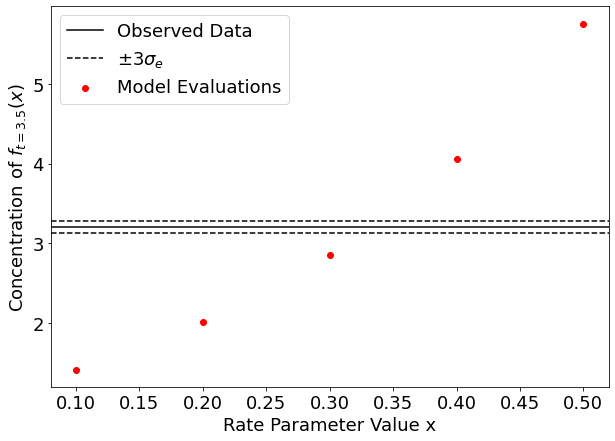

In [4]:
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(x_train, y_train, color='red', label='Model Evaluations')
ax.axhline(z, color='black', label='Observed Data')
ax.axhline(z-(3*sigma_e), linestyle='dashed', color='black', label='$\pm 3 \sigma_{e}$')
ax.axhline(z+(3*sigma_e), linestyle='dashed', color='black')
ax.set_xlabel('Rate Parameter Value x')
ax.set_ylabel('Concentration of $f_{t=3.5}(x)$')
ax.legend(loc='best')

In [5]:
# reshape vectors for use in kernel
x_train_T = np.reshape(x_train, (5,1))
y_train_T = np.reshape(y_train, (5,1))
x_test_T = np.reshape(x_test, (len(x_test),1))

In [6]:
# create squared-exponential kernel
d = 1              # no. of dimensions
sigma = 1.5        # sqrt variance of covariance function
theta = 0.14       # length scale
beta = 3.5         # prior expectation

def kernel(x1, x2, sigma, theta):
    # (norm of x1 - x2)^2 = norm x1 ^2 + norm x2 ^2 - 2 x1.x2   (ignore sqs as sqrt below)
    # norm of x1 = sqrt(x1_1 ^2 + x1_2^2 + ...)  (sum each column, equivalent to each input vector)
    
    # x1 is m x d array
    # x2 is n x d array
    # (m*n) combinations so want (m x n) covariance matrix eventually
    # norm(x1)(column vector) - norm(x2)(row vector) gives (m x n) array corresponding to each x1 and x2 combination
    # x1 dot x2.T gives equivalent (m x n) matrix of combinations
    
    
    if x1.ndim == 1:
        x1 = x1.reshape(-1, 1)
    if x2.ndim == 1:
        x2 = x2.reshape(-1, 1)
        
    
    norm_sq = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1)  - 2 * np.dot(x1, x2.T)
    K = sigma**2 * np.exp(- norm_sq / ((theta**2)))
    return K



In [27]:
# create posterior (using eqn 2.19 in Rasmussen)

def emulator(X_train, X_test, Y_train, sigma, theta, beta):
    
    K_XX = kernel(X_train, X_train, sigma, theta)
    K_XsX = kernel(X_test, X_train, sigma, theta)
    K_XXs = kernel(X_train, X_test, sigma, theta)
    K_XsXs = kernel(X_test, X_test, sigma, theta)
    K_XX_inv = np.linalg.inv(K_XX)
    
    mu = beta + K_XsX.dot(K_XX_inv).dot(Y_train - beta)
    cov = K_XsXs - K_XsX.dot(K_XX_inv).dot(K_XXs)
    
    print(K_XsX.dot(K_XX_inv).dot(K_XXs))
    sd = np.sqrt(np.diag(cov))
    
    
    return mu, cov, sd

In [28]:
# define implausibility measure

def implausibility(E, z, var, var_md, var_obs):
    
    # E - emulator expectation
    # z - observational data
    # var - credible interval
    # var_md - model discrepency error
    # var_obs - observational error
    
    return np.sqrt( ( E - z )**2  /  ( var + var_md + var_obs ) )

In [29]:
def plot_wave(X_train, X_test, Y_train, implaus_array, mu, sd, wave, ax=None):
    ax = ax
    ax.scatter(X_train, Y_train, color='red')
    ax.fill_between(X_test, mu.ravel() + 3*sd, mu.ravel() - 3*sd, alpha=0.2)
    ax.plot(X_test, mu)
    ax.set_title('Wave {}'.format(wave))
    ax.set_xlabel('Rate Parameter Value x')
    ax.set_ylabel('Concentration of $f_{t=3.5}(x)$')
    
    ax.axhline(z, color='black', label='Observed Data')
    ax.axhline(z-(3*sigma_e), linestyle='dashed', color='black', label='$\pm 3 \sigma_{e}$')
    ax.axhline(z+(3*sigma_e), linestyle='dashed', color='black')
    
    for i in range(len(x_test)):
        if implaus_array[i] > 3.5:
            ax.scatter(X_test[i], 1, color='red', marker='s')
        elif implaus_array[i] < 3:
            ax.scatter(X_test[i], 1, color='green', marker='s')
        else:
            ax.scatter(X_test[i], 1, color='orange', marker='s')

In [30]:
def history_match(X_train_0, X_test_0, Y_train_0, sigma, theta, beta, waves=1):
    
    # sigma - sqrt variance (covariance function)
    # theta - length scale (covariance function)
    # brta - prior expectation
    
    # X_train_0 = initial nonimplausible region, etc
    X_train = X_train_0
    X_test = X_test_0
    Y_train = Y_train_0
    
    fig, axes = plt.subplots(waves, 1, figsize=(12,8*waves))
    ax_list = fig.axes
    print(ax_list)
    
    for j in range(waves):
        
        ax=ax_list[j]
        
        N_points = len(X_train)
        
        # reshape vectors for use in kernel
        #X_train_T = np.reshape(X_train, (N_points,1))
        #Y_train_T = np.reshape(Y_train, (N_points,1))
        #X_test_T = np.reshape(X_test, (len(x_test),1))
        X_train_T = X_train
        Y_train_T = Y_train
        X_test_T = X_test

        # evaluate emulator
        mu, covariance, sd = emulator(X_train_T, X_test_T, Y_train_T, sigma, theta, beta)

        # evaluate implausibility over parameter space
        implaus_array = np.zeros(len(mu.ravel()))
        for i in range(len(mu.ravel())):
            fx = mu.ravel()[i]
            implaus_array[i] = implausibility(fx, z, np.diag(covariance)[i], 0, sigma_e**2)
        
        # plot emulator and implausibilities
        plot_wave(X_train, X_test, Y_train, implaus_array, mu, sd, j, ax=ax)

        # define new non-implausible region
        A = np.where(implaus_array > 3.5)
        x_test2 = np.delete(x_test, A)
        
        # select well-spaced training points in new nonimp region
        X1 = x_test2[0] + ( (x_test2[-1] - x_test2[0])/3 )
        X2 = x_test2[-1] - ( (x_test2[-1] - x_test2[0])/3 )
        
        # generate new training points over new nonimplausible region
        X_train = np.append(X_train, [X1, X2])
        Y_train = np.append(Y_train, [true_model(X1, 3.5), true_model(X2,3.5)])
    
    plt.savefig("1D_histmatch.png", facecolor='white', transparent=False)

[<AxesSubplot:>, <AxesSubplot:>]
[[2.18960347 2.19951681 2.20423678 ... 0.00660159 0.00841686 0.01019088]
 [2.19951681 2.21164517 2.21867406 ... 0.00547702 0.00696314 0.00841686]
 [2.20423678 2.21867406 2.22812516 ... 0.00432919 0.00547702 0.00660159]
 ...
 [0.00660159 0.00547702 0.00432919 ... 2.22812516 2.21867406 2.20423678]
 [0.00841686 0.00696314 0.00547702 ... 2.21867406 2.21164517 2.19951681]
 [0.01019088 0.00841686 0.00660159 ... 2.20423678 2.19951681 2.18960347]]
[[2.21602127 2.22103213 2.2208289  ... 0.00376375 0.00500996 0.00633921]
 [2.22103213 2.2291683  2.23218791 ... 0.00307303 0.00406693 0.0051292 ]
 [2.2208289  2.23218791 2.23854738 ... 0.00240135 0.00314668 0.0039461 ]
 ...
 [0.00376375 0.00307303 0.00240135 ... 2.24518414 2.24098812 2.23187203]
 [0.00500996 0.00406693 0.00314668 ... 2.24098812 2.24083675 2.23567397]
 [0.00633921 0.0051292  0.0039461  ... 2.23187203 2.23567397 2.23439352]]


 <ipython-input-27-2f3464aca3f3>:15: RuntimeWarning:invalid value encountered in sqrt


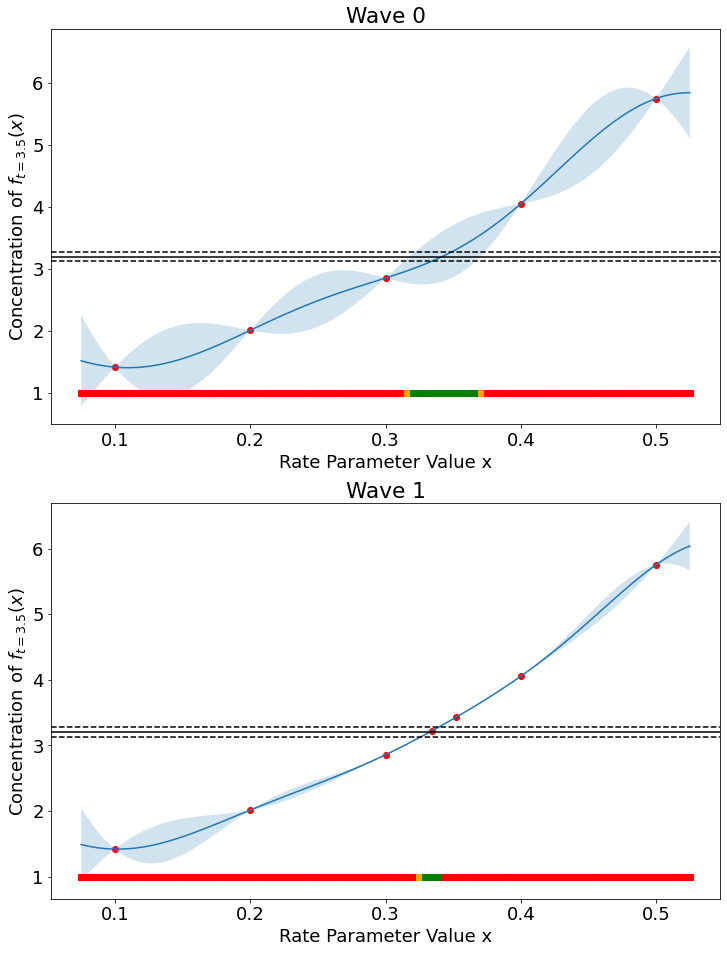

In [31]:
chi2 = history_match(x_train, x_test, y_train, sigma, theta, beta, 2)